In [6]:
import os

gpus = [0]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [7]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import socket
import sys
import h5py
import keras
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Activation, advanced_activations
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle
import spec_processing as spp
%matplotlib inline
from __future__ import division
from scipy.signal import spectrogram
import scipy.interpolate
import logging
import copy
import glob
import shutil
import os
import datetime
from random import shuffle
import IPython.display

In [8]:
#date and bird of data used
bird_id = 'z007'
model_name = 'spectrogram prediction model/mel'

#locate source folder
hostname = socket.gethostname()
print('The code is running on '+hostname + '\n')
    
if hostname in ['txori', 'passaro']:
    data_folder = os.path.abspath('/mnt/cube/kai/data')
    results_folder = os.path.abspath('/mnt/cube/kai/results/'+model_name)
    repos_folder = os.path.abspath('/mnt/cube/kai/repositories')
    data_folder_zeke = os.path.abspath('/mnt/cube/earneodo/bci_zf/ss_data')
    bird_folder_save = os.path.join(data_folder, bird_id)
    bird_folder_data = os.path.join(data_folder_zeke, bird_id)
else:
    data_folder = os.path.abspath('/Users/Kai/Documents/UCSD/Research/Gentner group/Raw Data')
    results_folder = os.path.abspath('/Users/Kai/Documents/UCSD/Research/Gentner group/Results/'+model_name)
    repos_folder = os.path.abspath('/Users/Kai/Documents/UCSD/Research/Gentner group/Code')
    bird_folder_save = os.path.join(data_folder, bird_id)
    bird_folder_data = bird_folder_save
    
if not os.path.exists(bird_folder_save):
    os.makedirs(bird_folder_save)

if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    
print('Bird data located at:\n'+bird_folder_data+'\n')
print('Results will be saved at:\n'+results_folder+'\n')

output_file = os.path.join(results_folder, 'mel_spec_predicted.dat')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

from dynamo import finch as zf
from dynamo import takens as tk
from bci.core import expstruct as es
from bci import synthetic as syn

The code is running on passaro

Bird data located at:
/mnt/cube/earneodo/bci_zf/ss_data/z007

Results will be saved at:
/mnt/cube/kai/results/spectrogram prediction model/mel



## Make Datasets

In [9]:
neural_kwik_name = 'experiment.kwik'
song_kwik_name = 'experiment.sng.kwe'
song_length = 20480
bin_size = 128
num_clusters = 64
num_lookbacks = 10

start_extend_bins = 0
end_extend_bins = 0
n_mel_freq = 128

Start working on /mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-11


IOError: [Errno 13] Permission denied: '/mnt/cube/kai/data/z007/day-2016-09-11/motif 0 419723.png'

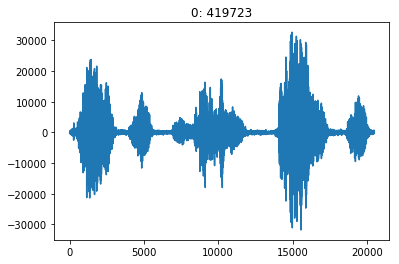

In [10]:
reload(spp)
datasets = spp.spike_sort(neural_kwik_name, song_kwik_name, song_length, bin_size, num_clusters, num_lookbacks, start_extend_bins=start_extend_bins, 
               end_extend_bins=end_extend_bins, specify_subdir = 'day-2016-09-11', n_mel_freq_components = n_mel_freq)

In [11]:
def make_train_test(dataset, num_bins, divisor=4, break_song=False, test_index=3, cross_valid=False):
    
    if test_index>divisor-1 or type(test_index)!=int:
        raise ValueError('test_index should be an integer less than or equal to 3.')
    if type(divisor)!=int or divisor<1:
        raise ValueError('divisor should be an integer greater than or equal to 1.')
       
    valid_index = test_index-1
    
    if valid_index<0:
        valid_index = divisor-1
    
    num_songs = int(len(dataset)/int(num_bins))
    
    #print('Total number of songs loaded:'+str(num_songs))
    
    if break_song:
        
        #break songs into roughly equal parts
        num_bins_each_part = spp.divide_parts(num_bins, divisor)
        start_indeces, end_indeces = spp.find_start_end_index(num_bins_each_part)
        
        num_current_test = num_bins_each_part[test_index]
        num_current_valid = num_bins_each_part[valid_index]*cross_valid
        num_current_train = num_bins-num_current_test-num_current_valid
        
        #print('Breaking up each song into '+str(num_current_train)+' training points and '+str(num_current_test)+' testing points.')
        #print('Currently testing on part No.'+str(test_index+1)+' of the '+ str(divisor)+' parts.')
        
        train_list = list()
        test_list = list()
        valid_list = list()
        temp_test = list()
        temp_train = list()
        temp_valid = list()
        
        for i in range(num_songs):
            this_song = dataset[i*num_bins:(i+1)*num_bins]
            bins_by_part = list()
            for j in range(len(num_bins_each_part)):
                start_index = start_indeces[j]
                end_index = end_indeces[j]
                if test_index == j:
                    temp_test = temp_test+this_song[start_index:end_index]
                elif valid_index == j and cross_valid:
                    temp_valid = temp_valid+this_song[start_index:end_index]
                else:
                    temp_train = temp_train+this_song[start_index:end_index]
                    
        #separate neural and song data
        for i in range(len(dataset[0])):            
            train_list.append([train_set[i] for train_set in temp_train])
            test_list.append([test_set[i] for test_set in temp_test])
            valid_list.append([valid_set[i] for valid_set in temp_valid])
        
        
    else:
        num_songs_each_part = spp.divide_parts(num_songs, divisor)
        num_test = num_songs_each_part[test_index]*num_bins
        num_valid = num_songs_each_part[valid_index]*num_bins
        num_train = len(datasets)-num_test-num_valid*cross_valid
        
        start_indeces, end_indeces = spp.find_start_end_index(num_songs_each_part)
        
    
        print('Not breaking up songs. There are '+str(num_train)+' training sets, and '+str(num_test)+' testing sets.\n')
    
        train_list = list()
        test_list = list()
        valid_list = list()
        temp_test = list()
        temp_train = list()
        temp_valid = list()
        
        #separate neural and song data
        for j in range(divisor):
            start_index = start_indeces[j]*num_bins
            end_index = end_indeces[j]*num_bins
            
            if test_index == j:
                temp_test = temp_test+datasets[start_index:end_index]
            elif valid_index == j and cross_valid:
                temp_valid = temp_valid+datasets[start_index:end_index]
            else:
                temp_train = temp_train+datasets[start_index:end_index]
                
        for i in range(len(dataset[0])):
            train_list.append([train_set[i] for train_set in temp_train])
            test_list.append([test_set[i] for test_set in temp_test])
            valid_list.append([valid_set[i] for valid_set in temp_valid])
        
    return train_list, test_list, valid_list

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

In [13]:
break_song = False
num_bins = song_length//bin_size+(end_extend_bins-start_extend_bins)*16-2
print(num_bins)
divisor= 10
l2_val = 0.001
dropout_val = 0.2
cross_valid = False
num_neurons = [20, 30]
num_ep = 30
early_stopping = True
valid_split = 0.1
test4valid = False
num_songs = len(datasets)//num_bins
if len(datasets)%num_bins:
    raise ValueError('number of songs is not integer')

158


NameError: name 'datasets' is not defined

In [74]:
#test_indeces = spp.assign_test_indeces(divisor, break_song=break_song)
#del model
test_indeces = [7]
#test_indeces = range(10)
print(test_indeces)

num_bins_per_part = spp.divide_parts(num_bins, divisor)
start_index, end_index = spp.find_start_end_index(num_bins_per_part)

[7]


## Build and train model

In [ ]:
test_output_compiled = list()
test_spec_compiled = list()

save_name = '[%d_%d_%02d]_%02d_%02d_[%s_%.2f]_[%02d_%02d]_%.3f_%02dep_%s' %(start_extend_bins, end_extend_bins, num_lookbacks, divisor, 
                                                            test_indeces[0], cross_valid, valid_split, num_neurons[0], 
                                                            num_neurons[1], l2_val, num_ep, break_song)
#save_name example:[2_2_10]_10_7_[False_0.10]_[20_30]_0_2ep_True
run_folder = os.path.join(results_folder, '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()))
if not os.path.exists(run_folder):
    os.makedirs(run_folder)

    
if early_stopping and not (cross_valid or valid_split or test4valid):
    raise ValueError('if early stopping, you need to have validation sets.')
    
for test_index in test_indeces:
    
    if break_song:
        print('Starting preparing for No.'+ str(test_index+1)+ ' of '+str(divisor)+' parts.')
        
    train_list, test_list, valid_list = make_train_test(datasets, num_bins, divisor=divisor, 
                                                        break_song=break_song, test_index=test_index, 
                                                        cross_valid=cross_valid)
    #both lists [neural data, on/off, beta, alpha]
    train_neuro = np.array(train_list[0])
    test_neuro = np.array(test_list[0])    

    train_spec = np.array(train_list[1])
    test_spec = np.array(test_list[1])

    #train_neuro = scaler.fit_transform(train_neuro)
    #test_neuro = scaler.fit_transform(test_neuro)

    train_neuro = np.reshape(train_neuro, (train_neuro.shape[0], num_lookbacks, num_clusters))
    test_neuro = np.reshape(test_neuro, (test_neuro.shape[0], num_lookbacks, num_clusters))
    
    if cross_valid:
        valid_neuro = np.array(valid_list[0])
        valid_spec = np.array(valid_list[1])
        valid_neuro = np.reshape(valid_neuro, (valid_neuro.shape[0], num_lookbacks, num_clusters))
    
    #train_neuro = np.reshape(train_neuro, (train_neuro.shape[0], 1, train_neuro.shape[1]))
    #test_neuro = np.reshape(test_neuro, (test_neuro.shape[0], 1, test_neuro.shape[1]))

    model = Sequential()

    #num_lookback = len(datasets[0][0])//num_channels
    #print('The number of lookbacks in this model is '+ str(num_lookbacks) + '\n')


    model.add(LSTM(num_neurons[0], input_shape = (num_lookbacks, num_clusters),return_sequences=True, W_regularizer=l2(l2_val)))
    #model1.add(LSTM(10, input_dim = num_lookback*num_channels,return_sequences=True))
    model.add(Dropout(dropout_val))
    model.add(LSTM(num_neurons[1], W_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(Dense(len(datasets[0][1]), W_regularizer=l2(l2_val)))

    print('Model building finished.')
    
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    current_ep_count=0
    
    if early_stopping:
        model_file = os.path.join(run_folder, '%02d_weights-improvement.h5' %(test_index))
        callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
                     ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)
                    ]
        if valid_split:
            model.fit(train_neuro, train_spec, nb_epoch=num_ep, batch_size=1, verbose=int(len(test_indeces)==1), 
                      validation_split=valid_split, callbacks=callbacks)
        elif test4valid:
            model.fit(train_neuro, train_spec, nb_epoch=num_ep, batch_size=1, verbose=int(len(test_indeces)==1), 
                      validation_data=(test_neuro, test_spec), callbacks=callbacks)
        else:
            model.fit(train_neuro, train_spec, nb_epoch=num_ep, batch_size=1, verbose=int(len(test_indeces)==1), 
                      validation_data=(valid_neuro, valid_spec), callbacks=callbacks)
        del model
        model = load_model(model_file)
    
    else:
        model_file = os.path.join(run_folder, '%02d_weights-improvement.h5' %(test_index))
        model.fit(train_neuro, train_spec, nb_epoch=num_ep, batch_size=1, verbose=int(not break_song))
        model.save(model_file)
        
        

    '''
    save_name = '90%_30_20_0_4ep_'
    save_file = os.path.join(results_folder, save_name+'.h5')

    model1.save(save_file)
    '''
    test_output = model.predict(test_neuro)
    
    test_output_compiled.append(test_output)
    test_spec_compiled.append(test_spec)
    print('Data recorded.')
    
    print('-'*50+'\n')

save_file = os.path.join(run_folder,save_name+'.p')
pickle.dump([test_output_compiled, test_spec_compiled], open(save_file, 'w'))

Not breaking up songs. There are 13114 training sets, and 1422 testing sets.

Model building finished.
Train on 11802 samples, validate on 1312 samples
Epoch 1/30
11802/11802 [==============================] - 646s - loss: 0.3537 - val_loss: 0.2116
Epoch 2/30
11802/11802 [==============================] - 644s - loss: 0.2348 - val_loss: 0.1949
Epoch 3/30
11802/11802 [==============================] - 644s - loss: 0.2095 - val_loss: 0.1832
Epoch 4/30
11802/11802 [==============================] - 627s - loss: 0.1963 - val_loss: 0.1730
Epoch 5/30
  144/11802 [..............................] - ETA: 614s - loss: 0.1826

In [ ]:
print('finished')

In [ ]:
##TEST ONLY
#print('program finished')

#del model
# returns a compiled model
# identical to the previous one
#save_name = '[%d_%d_%d]_%d_%d_[%s_%.2f]_[%d_%d]_%.3f_%dep_%s' %(start_extend_bins, end_extend_bins, num_lookbacks, divisor, 
#                                                            test_indeces[0], cross_valid, valid_split, num_neurons[0], 
#                                                            num_neurons[1], l2_val, num_ep, break_song)
run_folder = os.path.join(results_folder, '2017_04_18_14_47_54')
model_file = os.path.join(run_folder, 'weights-improvement-15-0.1212.h5')
model = load_model(model_file)

In [ ]:
#TEST ONLY
del model

In [ ]:
#TEST ONLY
test_index = test_indeces[0]
test_output_compiled = list()
test_spec_compiled = list()

train_list, test_list, valid_list = make_train_test(datasets, num_bins, divisor=divisor, 
                                                    break_song=break_song, test_index=test_index, 
                                                    cross_valid=cross_valid)
#both lists [neural data, on/off, beta, alpha]
train_neuro = np.array(train_list[0])
test_neuro = np.array(test_list[0])    

train_spec = np.array(train_list[1])
test_spec = np.array(test_list[1])

#train_neuro = scaler.fit_transform(train_neuro)
#test_neuro = scaler.fit_transform(test_neuro)

train_neuro = np.reshape(train_neuro, (train_neuro.shape[0], num_lookbacks, num_clusters))
test_neuro = np.reshape(test_neuro, (test_neuro.shape[0], num_lookbacks, num_clusters))


test_output = model.predict(test_neuro)
    
test_output_compiled.append(test_output)
test_spec_compiled.append(test_spec)

In [ ]:
##TEST ONLY
save_name = '[%d_%d_%d]_%d%%_[%d_%d]_%d_%dep_%s' %(start_extend_bins, end_extend_bins, num_lookbacks, pctg, num_neurons[0], num_neurons[1], l2_val, num_ep, break_song)
#save_name example:[2_2_10]_90%_[20_30]_0_2ep_True
run_folder = os.path.join(results_folder, save_name)
if not os.path.exists(run_folder):
    os.makedirs(run_folder)
save_file = os.path.join(run_folder, save_name+'.p')
pickle.dump([test_output_compiled, test_spec_compiled], open(save_file, 'w'))

In [84]:
#[test_output_compiled, rmse, example_test_output] = pickle.load(open(save_file, 'rb'))
#print(np.mean(rmse))
num_bins_per_part = spp.divide_parts(num_songs, divisor)
start_index, end_index = spp.find_start_end_index(num_bins_per_part)
print(start_index)

[0, 10, 20, 29, 38, 47, 56, 65, 74, 83]


In [78]:
##TEST ONLY
A = [2,3,4,5]
print(test_indeces)
A[test_indeces]

[7]


TypeError: list indices must be integers, not list

In [88]:
##TEST ONLY
def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = spp.xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

In [79]:
reload(spp)
predicted_song_compiled, original_song_compiled, rmse = spp.sort_songs(test_output_compiled, test_spec_compiled,
                                                                       num_songs, num_bins, divisor, 
                                                                       break_song=break_song, test_indeces=test_indeces)

[0.37714627, 0.30452693]


In [86]:
save_file = os.path.join(run_folder,save_name+'.p')
pickle.dump([predicted_song_compiled, original_song_compiled, rmse], open(save_file, 'w'))

In [85]:
import heapq
print(num_bins_per_part[test_indeces[0]])
print(pd.DataFrame(rmse)[0])
print(np.mean(rmse))
print(heapq.nlargest(4, rmse))

9
0    0.347507
1    0.326894
2    0.304527
3    0.377146
4    0.341419
5    0.330230
6    0.331320
7    0.328610
8    0.320705
Name: 0, dtype: float64
0.334262
[0.37714627, 0.34750682, 0.34141922, 0.33132038]


In [29]:
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 5 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 1 # how much should we compress the x-axis (time)
start_freq = 200 # Hz # What frequency to start sampling our melS from 
end_freq = 15000 # Hz # What frequency to stop sampling our melS from 
rate = 30000
mel_filter, mel_inversion_filter = spp.create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq, samplerate=rate)

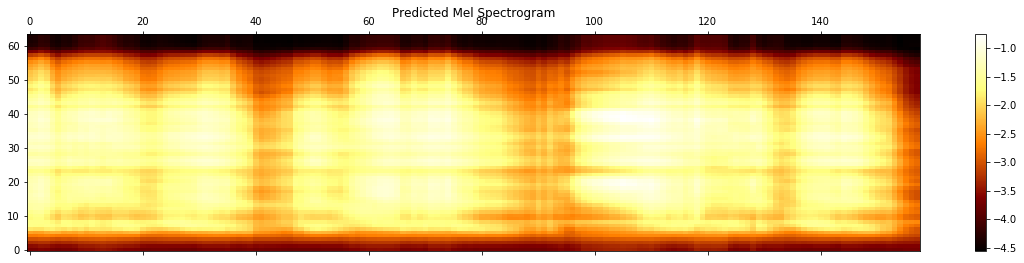

In [30]:
song_index = 7
example = np.array(predicted_song_compiled[song_index]).transpose()
spp.plotspec(example)
plt.title('Predicted Mel Spectrogram')
#plt.savefig(os.path.join(run_folder, '%d_p.png' %(song_index)))

In [ ]:
inverted_mel_audio = spp.spec2wav(example, mel_inversion_filter, spec_thresh, shorten_factor, fft_size, step_size)
plt.plot(inverted_mel_audio)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

In [ ]:
original = np.array(original_song_compiled[song_index]).transpose()
spp.plotspec(original)
plt.title('Original Mel Spectrogram')
plt.savefig(os.path.join(run_folder, '%d_o.png' %(song_index)))

In [ ]:
original_mel_audio = spp.spec2wav(original, mel_inversion_filter, spec_thresh, shorten_factor, fft_size, step_size)
plt.plot(original_mel_audio)
IPython.display.Audio(data=original_mel_audio, rate=rate)

In [ ]:
break_song = True
divisor=60

rmse = list()
test_output_compiled = list()
example_test_output = list()

for test_index in range(divisor):
    
    print('Starting preparing for No.'+ str(test_index+1)+ ' of '+str(divisor)+' parts.')

    train_list, test_list = make_train_test(datasets, num_bins, divisor=divisor, break_song=break_song, test_index = test_index)
    #both lists [neural data, on/off, beta, alpha]
    train_neuro = np.array(train_list[0])
    test_neuro = np.array(test_list[0])

    train_spec = np.array(train_list[1])
    test_spec = np.array(test_list[1])

    #train_neuro = train_neuro/np.max(train_neuro)
    #test_neuro = test_neuro/np.max(test_neuro)

    train_neuro = np.reshape(train_neuro, (train_neuro.shape[0], num_lookbacks, num_channels))
    test_neuro = np.reshape(test_neuro, (test_neuro.shape[0], num_lookbacks, num_channels))

    #train_neuro = np.reshape(train_neuro, (train_neuro.shape[0], 1, train_neuro.shape[1]))
    #test_neuro = np.reshape(test_neuro, (test_neuro.shape[0], 1, test_neuro.shape[1]))

    model1 = Sequential()

    #num_lookback = len(datasets[0][0])//num_channels
    #print('The number of lookbacks in this model is '+ str(num_lookbacks) + '\n')


    model1.add(LSTM(20, input_shape = (num_lookbacks, num_channels),return_sequences=True))
    #model1.add(LSTM(10, input_dim = num_lookback*num_channels,return_sequences=True))
    model1.add(Dropout(0.2))
    model1.add(LSTM(30))
    model1.add(Dropout(0.2))
    model1.add(Dense(len(datasets[0][1])))

    print('Model building finished.')
    
    model1.compile(loss = 'mean_squared_error', optimizer = 'adam')

    model1.fit(train_neuro, train_spec, nb_epoch=2, batch_size=1, verbose=1)
    
    original = np.loadtxt(os.path.join(bird_folder, 'mel_spectrogram.dat')).transpose()

    num_bins_per_part = divide_parts(num_bins, divisor)
    start_index, end_index = find_start_end_index(num_bins_per_part)

    original_part = original[:,start_index[test_index]:end_index[test_index]]
    
    train_output = model1.predict(train_neuro)
    test_output = model1.predict(test_neuro)

    example1 = test_output[:num_bins_per_part[test_index],:].transpose()
    
    rmse.append(np.sqrt(np.mean(np.square(example1-original_part))))
    
    test_output_compiled.append(test_output)
    
    example_test_output += list(example1.transpose())
    print('Data recorded.')
    
    print('-'*50+'\n')
    

In [ ]:
example1 = test_output[:2*num_bins,:].transpose()
testspec1 = test_spec[:2*num_bins,:].transpose()

rmse = np.sqrt(np.mean(np.square(example1-testspec1)))
print('RMS for this prediction is '+str(rmse))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(example1, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('predicted mel Spectrogram')
plt.savefig(os.path.join(results_folder, save_name+'.png'))

In [ ]:
fig1, ax1 = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax1 = ax1.matshow(testspec1, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig1.colorbar(cax1)
plt.title('original mel Spectrogram')
plt.savefig(os.path.join(results_folder, 'original.png'))

In [ ]:
original_inverted_spectrogram = spp.mel_to_spectrogram(testspec1, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)
inverted_original_audio = spp.invert_pretty_spectrogram(np.transpose(original_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
plt.plot(inverted_original_audio)
plt.savefig(os.path.join(results_folder, 'original_wav.png'))
IPython.display.Audio(data=inverted_original_audio, rate=rate)

In [ ]:
test_output = pickle.load(open(os.path.join(results_folder, '90%_30_20_nol2_4ep.p'), 'rb'))

In [ ]:
for i in range(int(7104//num_bins)):
    example = test_output[i*num_bins:(i+1)*num_bins,:].transpose()
    testspec = test_spec[i*num_bins:(i+1)*num_bins,:].transpose()

    rmse = np.sqrt(np.mean(np.square(example-testspec)))
    print('RMS for prediction '+str(i)+' is '+str(rmse))
    
    example_inverted_spectrogram = spp.mel_to_spectrogram(example, mel_inversion_filter,
                                                    spec_thresh=spec_thresh,
                                                    shorten_factor=shorten_factor)
    inverted_mel_audio = spp.invert_pretty_spectrogram(np.transpose(example_inverted_spectrogram), fft_size = fft_size,
                                                step_size = step_size, log = True, n_iter = 10)
    plt.figure()
    plt.title('predicted wav: '+str(i))
    plt.plot(inverted_mel_audio)
    
    plt.figure()
    original_inverted_spectrogram = spp.mel_to_spectrogram(testspec, mel_inversion_filter,
                                                    spec_thresh=spec_thresh,
                                                    shorten_factor=shorten_factor)
    inverted_original_audio = spp.invert_pretty_spectrogram(np.transpose(original_inverted_spectrogram), fft_size = fft_size,
                                                step_size = step_size, log = True, n_iter = 10)
    plt.title('original wav: '+str(i))
    plt.plot(inverted_original_audio)
    
    print('-'*60+'\n')

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

example_spec = np.array(example_test_output).transpose()
cax = ax.matshow(example_spec, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('predicted mel Spectrogram')

In [ ]:
matrix = np.matrix(test_neuro[5000].transpose())
plt.imshow(matrix)

In [ ]:
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 5 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 1 # how much should we compress the x-axis (time)
start_freq = 200 # Hz # What frequency to start sampling our melS from 
end_freq = 15000 # Hz # What frequency to stop sampling our melS from 
rate = 30000
mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq)

In [ ]:
example_inverted_spectrogram = mel_to_spectrogram(example_spec, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)
inverted_mel_audio = invert_pretty_spectrogram(np.transpose(example_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
plt.plot(inverted_mel_audio)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

In [ ]:
pickle.dump(test_output_compiled, open(os.path.join(results_folder,'shifting test model.p'),'wb'))
np.savetxt(os.path.join(results_folder,'example shifting test model.dat'), example_spec)

In [ ]:
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 5 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 1 # how much should we compress the x-axis (time)
start_freq = 200 # Hz # What frequency to start sampling our melS from 
end_freq = 15000 # Hz # What frequency to stop sampling our melS from 
rate = 30000

mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq)

predicted_inv_spec = mel_to_spectrogram(example1, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)
original_inv_spec = mel_to_spectrogram(original, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

predicted_inv_audio = invert_pretty_spectrogram(np.transpose(predicted_inv_spec), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

original_inv_audio = invert_pretty_spectrogram(np.transpose(original_inv_spec), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

plt.figure()
plt.plot(predicted_inv_audio)
plt.title('predicted waveform')
plt.figure()
plt.plot(original_inv_audio)
plt.title('source waveform')

IPython.display.Audio(data=predicted_inv_audio, rate=rate)

In [ ]:
IPython.display.Audio(data=original_inv_audio, rate=rate)

In [ ]:
save_name = 'mels_2030'

current_save_file = os.path.join(results_folder, save_name+'dat')
np.savetxt(current_save_file, test_output)


In [ ]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True)
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def stream_resample(stream, s_f, new_s_f):
    n_samples = stream.shape[0]
    new_samples = int(n_samples* new_s_f / s_f)
    if int(s_f) == int(new_s_f):
        resampled = stream
    elif int(s_f) < int(new_s_f):
        xcoords = np.linspace(0,n_samples,n_samples)
        newxcoords = np.linspace(0,n_samples,new_samples)
        resampled = list()
        print(type(resampled))
        for i in range(stream.shape[1]):
            ycoords = stream[:,i]
            newycoords = np.interp(newxcoords, xcoords, ycoords)
            resampled.append(newycoords)
    else:
        resampled = resample(stream, new_samples)
    return resampled

def load_syn_stream(syn_sess=1, s_f=44100, new_s_f=30000, parameter_file='./syn_bos.dat'):
    #stim_folder = et.file_names(bird)['folders']['stim']
    #syn_file = os.path.join(folder, bird_id, file_base + '.dat')
    return stream_resample(np.loadtxt(parameter_file), s_f, new_s_f)


In [ ]:
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = int((valid) // ss)
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in xrange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float16')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float16')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec


In [ ]:
def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)
    
def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.

    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"
    
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = np.zeros([nfilt,nfft//2])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300, end_freq = 8000, samplerate=44100):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(nfilt=n_freq_components, 
                                           nfft=fft_size, samplerate=samplerate, 
                                           lowfreq=start_freq, highfreq=end_freq)
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

In [ ]:
print('Test Score: %.4f RMSE' % (testScore))

In [ ]:
randtomtest = ['hog','rat']

In [ ]:
parameter_name = 'Alpha'
parameter_dic = {'Alpha':3, 'Beta':2, 'OnOff':1}
print(parameter_dic[parameter_name])

In [ ]:
type(testPredict)

In [ ]:
testytest = [1,2,3,4,5,6,7]
testyyy = [testytest[:3],testytest[2:5]]
print(testyyy)
print(sum(testytest[:0]))

In [ ]:
print(type([4]))